<a href="https://colab.research.google.com/github/krodri95/MNIST-Classifier/blob/main/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms, datasets
from torchvision.transforms import Resize

from PIL import Image
from tqdm import tqdm
import time
import numpy as np

from google.colab import files
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

print(torch.cuda.is_available())
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

True


In [3]:
def autopad(k, p=None):  # kernel, padding
    # Pad to 'same'
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
    return p


class Conv(nn.Module):
    # Standard convolution
    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, act=True):  # ch_in, ch_out, kernel, stride, padding, groups
        super().__init__()

        self.conv = nn.Conv2d(c1, c2, k, s, autopad(k, p), groups=g, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = nn.ReLU() if act is True else (act if isinstance(act, nn.Module) else nn.Identity())

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))


class Model(nn.Module):
    def __init__(self, nc=None):
        super().__init__()
        self.conv1 = Conv(1, 32, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = Conv(32, 64, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = Conv(64, 128, 3)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.flat =  nn.Flatten()
        self.fc1 = nn.Linear(128 * 6 * 6, 256)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(256*1*1, nc)


    def forward(self, x):
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = self.pool3(self.conv3(x))
        x = self.flat(x) # flatten all dimensions except batch
        x = self.drop(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [4]:
class RGB2BGR(object):
    """Convert RGB image to BGR image"""

    def __call__(self, img):

        data = np.array(img)
        print(data.shape)
        red, green, blue = data.T
        data = np.array([blue, green, red])
        data = data.transpose()
        img = Image.fromarray(data)
        return img

In [5]:
transform = transforms.Compose([Resize((50, 50), Image.BILINEAR),
                                #RGB2BGR(),
                                transforms.ToTensor()])

trainset = datasets.MNIST("", train=True, download=True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True)

testset = datasets.MNIST("", train=False, download=True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=True)

# Model
model = Model(nc=10).to(device)  # create

100%|██████████| 9912422/9912422 [00:00<00:00, 130803341.35it/s]


Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 109229660.80it/s]


Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41703448.59it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5455477.88it/s]


Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



In [81]:
epochs = 1
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Start training
t0 = time.time()

nb = len(trainloader)  # number of batches
running_loss = 0.0

for epoch in range(epochs):  # loop over the dataset multiple times

    model.train()
    pbar = enumerate(trainloader)
    print(('\n' + '%10s' * 2) % ('Epoch', 'mloss'))
    pbar = tqdm(pbar, total=nb, bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')  # progress bar
    running_loss = 0.0

    for i, data in pbar:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        pbar.set_description(('%10s' * 2) % (f'{epoch}/{epochs - 1}', f'{running_loss / (i+1):.3f}'))


    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        model.eval()
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(('%20s') % (f'Accuracy : {100 * correct / total:.3f} %'))


print(f'\n{epochs} epochs completed in {(time.time() - t0) / 3600:.3f} hours.')

# again no gradients needed



     Epoch     mloss


       0/0     0.017: 100%|██████████| 7500/7500 [01:00<00:00, 124.76it/s]


 Accuracy : 99.110 %

1 epochs completed in 0.017 hours.


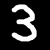

Predicted Class:  3


In [86]:
#f = files.upload()
img = cv2.imread('firstTest.png')
img = cv2.resize(img, (50,50))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = 255 - img #invert image
cv2_imshow(img)

img = torch.from_numpy(np.array(img/255)).float().to(device)
outputs = model(img.view(1,1,50,50))

# the class with the highest energy is what we choose as prediction
_, predicted = torch.max(outputs, 1)

print('Predicted Class: ', int(predicted))